# PilotNet SDNN Example

Network excange module is available as `lava.lib.dl.netx.{hdf5, blocks, utils}`.
* `hdf5` implements automatic network generation.
* `blocks` implements individual layer blocks.
* `utils` implements hdf5 reading utilities. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.proc.sdn.process import Delta
from lava.proc.sdn.models import AbstractDeltaModel, LavaPyType, PyInPort, PyOutPort, CPU
from lava.proc import io

from lava.lib.dl import netx
from dataset import PilotNetDataset

# Import modules for Loihi2 execution

Check if Loihi2 compiker is available and import related modules.

In [2]:
loihi2_is_available = netx.utils.Loihi2Exec.is_loihi2_available

if loihi2_is_available:
    import logging
    from lava.magma.core.run_configs import Loihi2HwCfg
    from lava.proc import snip_io as sio
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")
# loihi2_is_available = False

## Create network block

PilotNet SDNN is described by the hdf5 file interface `network.net` exported after training.

A network block can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as as a list: `net.layers`.

In [3]:
# We perform delta encoding calculation of first layer always on CPU and send it to Loihi2.
net = netx.hdf5.Network(net_config='network.net', skip_layers=1)
print(net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Conv      |   99|   32|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   49|   15|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   48| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Dense     |    1|    1|  100|     |     |     |     |     |False|
|Dense     |    1|    1|   50|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|
|Dense     |    1|    1|    1|     |     |     |     |     |False|


In [4]:
print(f'There are {len(net)} layers in network:')

for l in net.layers:
    print(f'{l.__class__.__name__:5s} : {l.name:10s}, shape : {l.shape}')

There are 9 layers in network:
Conv  : Process_3 , shape : (99, 32, 24)
Conv  : Process_6 , shape : (49, 15, 36)
Conv  : Process_9 , shape : (24, 7, 48)
Conv  : Process_12, shape : (22, 4, 64)
Conv  : Process_15, shape : (20, 2, 64)
Dense : Process_18, shape : (100,)
Dense : Process_21, shape : (50,)
Dense : Process_24, shape : (10,)
Dense : Process_27, shape : (1,)


## Set execution parameters
Configure execution timesteps, input shape and input transformation.

In [5]:
num_samples = 200
steps_per_sample = 1
num_steps = num_samples + len(net.layers)

In [6]:
input_size = net.net_config['layer'][0]['shape'][::-1][:2]
transform = {'weight': 64, 'bias': 0}
if 'weight' in net.net_config['layer'][0].keys():
    transform['weight'] = net.net_config['layer'][0]['weight']
if 'bias' in net.net_config['layer'][0].keys():
    transform['bias'] = net.net_config['layer'][0]['bias']

## Create Dataset instance
Typically the user would write it or provide it.

In [7]:
full_set = PilotNetDataset(
    path='../data',
    size=input_size,
    transform=transform, # input transform
    visualize=True, # visualize ensures the images are returned in sequence
    sample_offset=10550,
)
train_set = PilotNetDataset(
    path='../data',
    size=input_size,
    transform=transform, # input transform
    train=True,
)
test_set = PilotNetDataset(
    path='../data',
    size=input_size,
    transform=transform, # input transform
    train=False,
)

# Instantiate Dataloader

In [8]:
dataloader = io.dataloader.SpikeDataloader(dataset=full_set)

# Delta Encoder

Delta encodes performs frame difference of consecutive input frames which removes temporally redundant features and sparsifies the network input.

In [9]:
class DeltaEncoder(Delta):
    """Performs difference encoding of consecutive input frames to sparsify input."""
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

@implements(proc=DeltaEncoder, protocol=LoihiProtocol)
@requires(CPU)
class PyDeltaEncoderModel(AbstractDeltaModel):
    """Implementation of Delta encoder."""
    a_in = LavaPyType(PyInPort.VEC_DENSE, np.int32, precision=24)
    s_out = LavaPyType(PyOutPort.VEC_DENSE, np.int32, precision=24)

    vth: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=24)
    sigma: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=24)
    act: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=24)
    residue: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=24)
    error: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=24)

    spike_exp: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=3)
    state_exp: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=3)
    cum_error: np.ndarray = LavaPyType(np.ndarray, bool, precision=1)

    def run_spk(self) -> None:
        # Receive synaptic input
        a_in_data = np.left_shift(self.a_in.recv(),
                                  self.spike_exp + self.state_exp)
        s_out_scaled = self.delta_dynamics(a_in_data)
        s_out = np.right_shift(s_out_scaled, self.state_exp)
        self.act = a_in_data
        self.s_out.send(s_out)

input_encoder = DeltaEncoder(shape=tuple(net.net_config['layer'][0]['shape'][::-1]),
                             vth=net.net_config['layer'][0]['neuron']['vThMant'],
                             spike_exp=6, state_exp=6)

# Network visualizer

In [10]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import transforms

class PilotNetMonitor(AbstractProcess):
    def __init__(self, shape, fig, ax0, ax1, ax2) -> None:
        super().__init__(shape=shape)
        self.frame_in = InPort(shape=shape)
        self.output_in = InPort(shape=(1,))
        self.gt_in = InPort(shape=(1,))
        self.proc_params['fig'] = fig
        self.proc_params['ax0'] = ax0
        self.proc_params['ax1'] = ax1
        self.proc_params['ax2'] = ax2

@implements(proc=PilotNetMonitor, protocol=LoihiProtocol)
@requires(CPU)
class PilotNetMonitorModel(PyLoihiProcessModel):
    frame_in = LavaPyType(PyInPort.VEC_DENSE, float)
    output_in = LavaPyType(PyInPort.VEC_DENSE, float)
    gt_in = LavaPyType(PyInPort.VEC_DENSE, float)

    def __init__(self, proc_params=None) -> None:
        super().__init__(proc_params=proc_params)
        # self.fig = plt.figure(figsize=(15, 5))
        # self.ax1 = self.fig.add_subplot(1, 3, 1)
        # self.ax2 = self.fig.add_subplot(1, 3, 2)
        # self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.fig = self.proc_params['fig']
        self.ax1 = self.proc_params['ax0']
        self.ax2 = self.proc_params['ax1']
        self.ax3 = self.proc_params['ax2']
        self.ax1.set_title('Input Frame Difference')
        self.ax2.set_title('Network Prediction')
        self.ax2.set_ylabel('Prediction angle')
        self.ax2.set_xlabel('Frames')
        self.gt_history = [0] * 25  # We will see output only after 25 timesteps
        self.output_history = []


    def run_spk(self) -> None:
        frame_data = self.frame_in.recv()
        output_data = self.output_in.recv()[0]
        gt_data = self.gt_in.recv()[0]
        output = (output_data.astype(np.int32) << 8) >> 8
        angle = output / (1 << 18)
        self.gt_history.append(gt_data)
        self.output_history.append(angle)

        clear_output(wait=True)
        self.ax1.imshow(frame_data)
        self.ax2.imshow(frame_data)
        # self.ax3.clear()
        print(f'{self.gt_history=}')
        print(f'{self.output_history=}')
        self.ax3.plot(np.array(self.gt_history), label='ground truth')
        self.ax3.plot(np.array(self.output_history), label='network prediction')
        display(self.fig)
        plt.pause(1)

        


# Connect Input and Output

TODO: Add figure
![pilotnet](PilotNetSDNN.png)

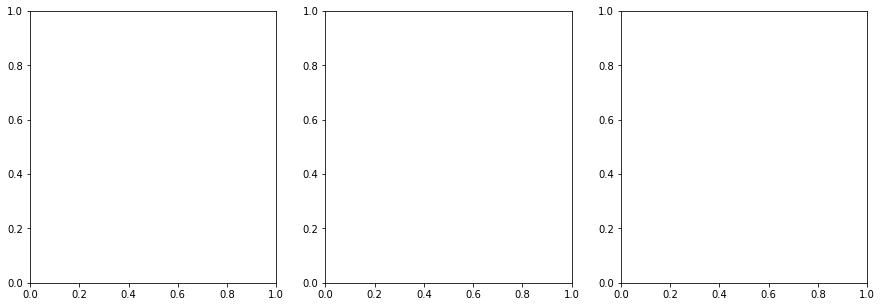

In [11]:
# Datalogger blocks
gt_logger = io.sink.RingBuffer(shape=(1,), buffer=num_steps)
output_logger = io.sink.RingBuffer(shape=net.out.shape, buffer=num_steps)

if loihi2_is_available:
    # Bridge blocks running on Loihi2 x86 processors to relay input and output.
    inp_adapter = sio.spike.PyToN3ConvAdapter(shape=net.inp.shape,
                                            num_message_bits=16)
    out_adapter = sio.spike.NxToPyAdapter(shape=net.out.shape,
                                        num_message_bits=32)

# # Monitor
# fig = plt.figure(figsize=(15, 5))
# ax0 = fig.add_subplot(1, 3, 1)
# ax1 = fig.add_subplot(1, 3, 2)
# ax2 = fig.add_subplot(1, 3, 3)
# monitor = PilotNetMonitor(shape=net.inp.shape,
#                           fig=fig, ax0=ax0, ax1=ax1, ax2=ax2)

# Create connections
dataloader.ground_truth.connect(gt_logger.a_in)
dataloader.s_out.connect(input_encoder.a_in)
if loihi2_is_available:
    input_encoder.s_out.connect(inp_adapter.inp)
    inp_adapter.out.connect(net.inp)
    net.out_layer.out.connect(out_adapter.inp)
    out_adapter.out.connect(output_logger.a_in)
else:
    input_encoder.s_out.connect(net.inp)
    net.out_layer.out.connect(output_logger.a_in)
    # input_encoder.s_out.connect(monitor.frame_in)
    # dataloader.ground_truth.connect(monitor.gt_in)
    # net.out_layer.out.connect(monitor.output_in)

## Run

### Customize Run Configuration (Only for CPU execution)

In [12]:
class CustomRunConfig(Loihi1SimCfg):
    def select(self, proc, proc_models):
        # customize run config to always use float model for io.sink.RingBuffer
        if isinstance(proc, io.sink.RingBuffer):
            return io.sink.PyReceiveModelFloat
        else:
            return super().select(proc, proc_models)

### Run the network

In [13]:
if loihi2_is_available:
    run_config = Loihi2HwCfg()
else:
    run_config = CustomRunConfig(select_tag='fixed_pt')
net._log_config.level = logging.INFO
net.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
output = output_logger.data.get().flatten()
gts = gt_logger.data.get().flatten()
net.stop()

if loihi2_is_available:
    # reinterpret the data as 24 bit signed value
    output = (output.astype(np.int32) << 8) >> 8


self.gt_history=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.045727626402251434, 0.0439822971502571, 0.040491638646268445, 0.03700098014227979, 0.035255650890285456, 0.035255650890285456, 0.03700098014227979, 0.03874630939427412, 0.03874630939427412, 0.040491638646268445, 0.040491638646268445, 0.040491638646268445, 0.040491638646268445, 0.03700098014227979, 0.033510321638291124, 0.0317649923862968, 0.0317649923862968, 0.0317649923862968, 0.029845130209103034, 0.021118483949131385, 0.0017453292519943296, -0.021118483949131385, -0.045727626402251434, -0.05986479334340551, -0.0651007810993885, -0.06859143960337716, -0.08098327729253689, -0.10035643198967394, -0.130201562198777, -0.18832102629018815, -0.23753931119642827, -0.290248254606657, -0.3274237676741363, -0.3659955441432109, -0.4082325120414737, -0.43301618741979314, -0.48397980157802756, -0.5279620987282847, -0.5878268920716901, -0.6407103684071184, -0.6846926655573754, -0.7918558816298272, -0

KeyboardInterrupt: 

## Evaluate Results
Plot and compare the results with the dataset ground truth.

In [ ]:
# There is an additional 1 timestep delay for spike transmission between output layer to x86 processor
offset = 2 if loihi2_is_available else 1
    
plt.figure(figsize=(7, 5))
plt.plot(np.array(gts), label='Ground Truth')
plt.plot(np.array(output[len(net.layers) + offset:]).flatten()/(1<<18), label='Lava output')
plt.xlabel(f'Sample frames (+10550)')
plt.ylabel('Steering angle (radians)')
plt.legend()